In [1]:
import numpy as np
import pandas as pd 
from glob import glob
from os import path
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from torch.autograd import Variable
import torch.utils.data as utils
from time import sleep
import tensorflow as tf
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.model_selection import train_test_split

/Users/shauryas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [78]:
seed = 0
sequence_size = 10
np.random.seed(seed)
N = 5000
split_idx = int(N*0.8)

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split

class TimeSeriesData:
    def __init__(self, num_datapoints, test_size=0.2, max_t=20, num_prev=1,
                 noise_var=1):
        """
        Template class for generating time series data.
        :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
        """
        self.num_datapoints = num_datapoints
        self.test_size = test_size
        self.num_prev = num_prev
        self.max_t = max_t
        self.data = None
        self.noise_var = noise_var
        self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
        self.bayes_preds = np.copy(self.y)

        # Generate data and reshape data
        self.create_data()

        # Split into training and test sets
#         self.train_test_split()

    def create_data(self):
        self.generate_data()
#         self.reshape_data()

    def generate_data(self):
        """Generates data in self.y, may take as implicit input timesteps self.t.
        May also generate Bayes predictions."""
        raise NotImplementedError("Generate data method not implemented.")

    def reshape_data(self):
        self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
            self.num_datapoints)], (-1, self.num_prev))
        self.y = np.copy(self.y[self.num_prev:])
        self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

    def train_test_split(self):
        test_size = int(len(self.y) * self.test_size)
        self.data = [self.X_train, self.X_test, self.y_train,
                     self.y_test] = \
                    self.x[:-test_size], self.x[-test_size:], \
                    self.y[:-test_size], self.y[-test_size:]
        self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]

    def return_data(self):
        return self.data

    def return_train_test(self):        
        return self.X_train, self.y_train, self.X_test, self.y_test
    
class ARData(TimeSeriesData):
    """Class to generate autoregressive data."""

    def __init__(self, *args, coeffs=None, **kwargs):
        self.given_coeffs = coeffs
        super(ARData, self).__init__(*args, **kwargs)

        if coeffs is not None:
            self.num_prev = len(coeffs) - 1

    def generate_data(self):
        self.generate_coefficients()
        self.generate_initial_points()

        # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
        # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
        for i in range(self.num_datapoints+3*self.num_prev):
            # Generate y value if there was no noise
            # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
            self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
            # Add noise
            self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()

        # Cut first 20 points so dist is roughly stationary
        self.bayes_preds = self.bayes_preds[3*self.num_prev:]
        self.y = self.y[3*self.num_prev:]

    def generate_coefficients(self):
        if self.given_coeffs is not None:
            self.coeffs = self.given_coeffs
        else:
            filter_stable = False
            # Keep generating coefficients until we come across a set of coefficients
            # that correspond to stable poles
            while not filter_stable:
                true_theta = np.random.random(self.num_prev) - 0.5
                coefficients = np.append(1, -true_theta)
                # check if magnitude of all poles is less than one
                if np.max(np.abs(np.roots(coefficients))) < 1:
                    filter_stable = True
            self.coeffs = true_theta

    def generate_initial_points(self):
        # Initial datapoints distributed as N(0,1)
        self.y[:self.num_prev] = np.random.randn(self.num_prev)

    def noise(self):
        # Noise distributed as N(0, self.noise_var)
        return self.noise_var * np.random.randn()

# A set of coefficients that are stable (to produce replicable plots, experiments)
fixed_ar_coefficients = {2: [ 0.46152873, -0.29890739],
    5: [ 0.02519834, -0.24396899,  0.2785921,   0.14682383,  0.39390468],
                        10: [-0.10958935, -0.34564819,  0.3682048,   0.3134046,  -0.21553732,  0.34613629,
  0.41916508,  0.0165352,   0.14163503, -0.38844378],
                         20: [ 0.1937815,   0.01201026,  0.00464018, -0.21887467, -0.20113385, -0.02322278,
  0.34285319, -0.21069086,  0.06604683, -0.22377364,  0.11714593, -0.07122126,
 -0.16346554,  0.03174824,  0.308584,    0.06881604,  0.24840789, -0.32735569,
0.21939492, 0.3996207 ]}

In [188]:
batch_size = 1

In [193]:
data = ARData(16*(N+sequence_size), coeffs=fixed_ar_coefficients[10], num_prev=10)

In [195]:

sequences = np.reshape(data.y[:-sequence_size], (batch_size, -1))

In [196]:
sequences = np.expand_dims(sequences, -1)

In [197]:
sequences.shape

(1, 80160, 1)

In [205]:
split_idx = int(sequences.shape[1]*0.8)

In [206]:
split_idx

64128

In [207]:
X = sequences[:,:-sequence_size]

In [208]:
y = sequences[:, sequence_size:]

In [209]:
X_train = X[:,:split_idx]
X_test = X[:,split_idx:]
y_train = y[:,:split_idx]
y_test = y[:,split_idx:]

In [210]:
X_train.shape

(1, 64128, 1)

In [211]:
y_test.shape

(1, 16022, 1)

In [15]:
# AR_object2 = ArmaProcess(np.array([1, -0.999]), np.array([1]))
# y = AR_object2.generate_sample(nsample=N + sequence_size)
# y = y.astype(np.float32)

In [13]:
# y = np.sin(np.linspace(0,int(50*2*np.pi), N+sequence_size)).astype(np.float32)

In [60]:
# X = np.expand_dims(y[:-sequence_size], -1)
# y = np.expand_dims(y[sequence_size:], -1)


In [61]:
# X_train = X[:split_idx]
# y_train = y[:split_idx]
# X_test = X[split_idx:]
# y_test = y[split_idx:]

In [212]:
def strided_app(a, L, S):
    nrows = ((a.shape[0]-L)//S)+1
    
    n = a.strides[0]    
    if len(a.shape) > 1:
        ncols = a.shape[1]        
        strides = (S*n, n, a.strides[1])
    else:
        ncols = 1
        strides = (S*n,n)
    shape = (nrows,L, ncols)
    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=(S*n,n, a.strides[1]))

In [213]:
def get_subsequences(x, window_size, step=1):
    # x : (batch_size, seq_len, features)
    # Split a batch of sequence data to generate all the subsequences
    # with a step size of 1 are returned.        
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    if len(x.shape) > 2:
        num_features = x.shape[2]
    else:
        num_features = 1
        
    
    assert(window_size <= seq_len)
    num_steps = (seq_len - window_size + 1)//step
    nrows = ((seq_len - window_size)//step) + 1
    
    batched_subsequences = np.empty((batch_size, nrows, window_size, num_features))
    for i in range(batch_size):
        batched_subsequences[i,:,:] = strided_app(x[i], window_size, step)
    
    for i in range(nrows):
        yield batched_subsequences[:,i]

In [214]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, stateful=True, batch_input_shape=(batch_size,sequence_size,1)))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [215]:

for e in range(5):
    model.reset_states()
    train_mse = []
    X_gen = get_subsequences(X_train, sequence_size)
    y_gen = get_subsequences(y_train, 1)
    batch_gen = zip(X_gen, y_gen)
    for batch_data, batch_label in batch_gen:
        batch_label = np.squeeze(batch_label, -1)
        loss, mse = model.train_on_batch(batch_data, batch_label)
        train_mse.append(mse)
    print('Epoch {}'.format(e))
    print('train mse {}'.format(np.mean(train_mse)))
        
    model.reset_states()
    test_mse = []
    X_test_gen = get_subsequences(X_test, sequence_size)
    y_test_gen = get_subsequences(y_test, 1)
    batch_gen = zip(X_test_gen, y_test_gen)
    for batch_data, batch_label in batch_gen:
        batch_label = np.squeeze(batch_label, -1)
        
        loss, mse = model.test_on_batch(batch_data, batch_label)
        test_mse.append(mse)
        
    print('test mse {}'.format(np.mean(test_mse)))


Epoch 0
train mse 1.4080824851989746
test mse 1.282564640045166


KeyboardInterrupt: 

In [182]:
model.reset_states()
preds = []
X_test_gen = get_subsequences(X_test, sequence_size)
y_test_gen = get_subsequences(y_test, 1)
batch_gen = zip(X_test_gen, y_test_gen)
for batch_data, batch_label in batch_gen:
    batch_label = np.squeeze(batch_label, -1)
    pred = model.predict_on_batch(batch_data)    
    preds.append(pred)

In [183]:
preds = np.array(preds)

In [184]:
preds = np.reshape(preds, (batch_size,-1,1))

In [185]:
preds.shape

(16, 991, 1)

In [186]:
preds = preds.squeeze(-1)

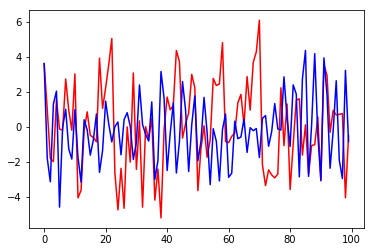

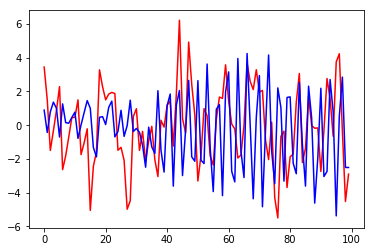

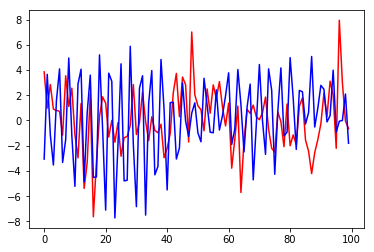

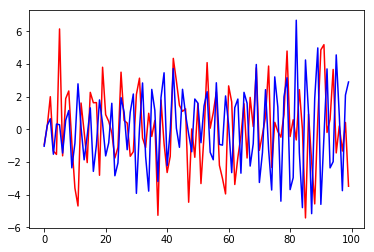

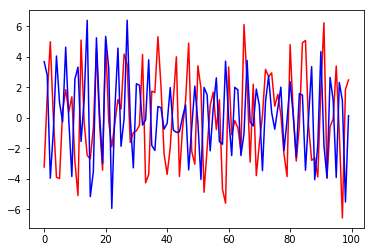

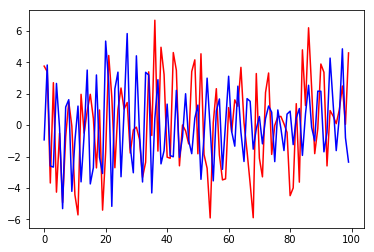

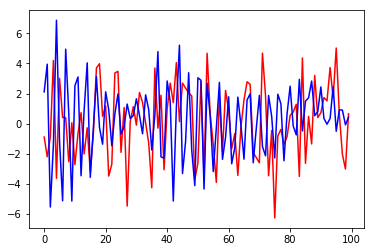

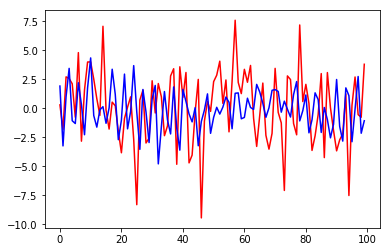

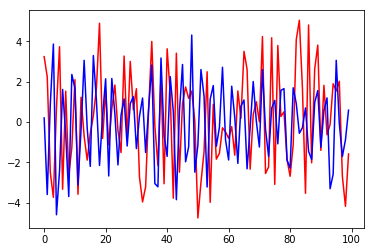

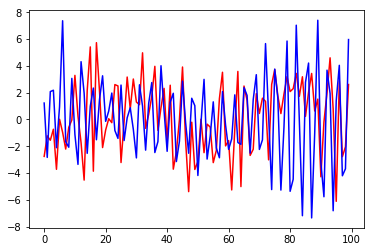

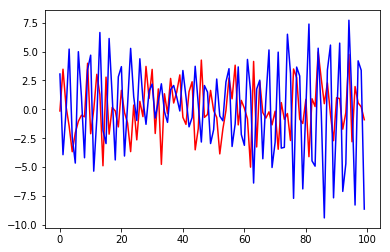

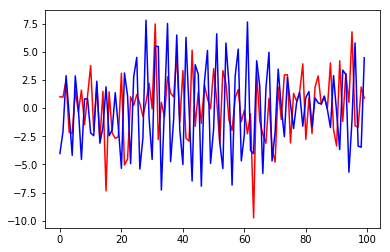

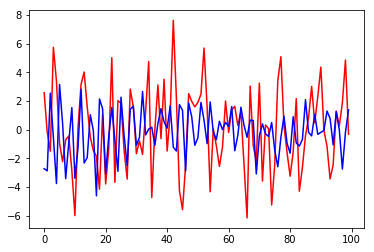

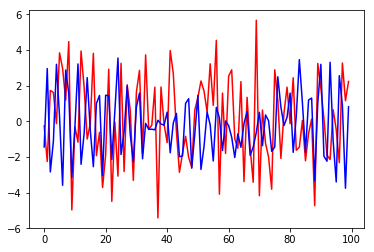

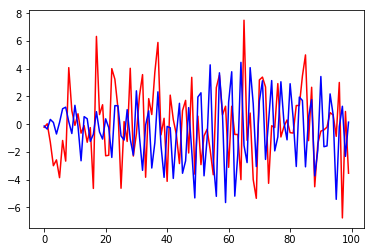

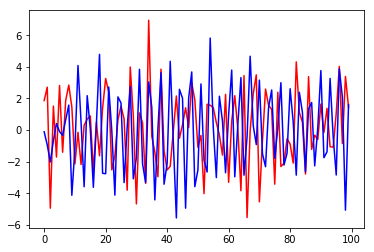

In [187]:
for i in range(batch_size):
#     print(preds[i].shape)
#     print(y_test[i].shape)
    plt.figure()
    plt.plot(range(100), preds[i,:100], 'r', y_test[i,:100], 'b')

In [63]:

# for _ in range(5):
#     model.reset_states()
#     train_acc = []
#     for i in range(X_train.shape[0] - sequence_size):
#         batch_data = np.expand_dims(X_train[i:i+sequence_size], 0)
#         batch_label = y_train[i]
#         loss, acc = model.train_on_batch(batch_data, batch_label)
#         train_acc.append(acc)
#     print('train acc {}'.format(np.mean(train_acc)))
        
#     model.reset_states()
#     test_acc = []
#     for i in range(X_test.shape[0] - sequence_size):
#         batch_data = np.expand_dims(X_test[i:i+sequence_size], 0)
#         batch_label = y_test[i]
#         loss, acc = model.test_on_batch(batch_data, batch_label)
#         test_acc.append(acc)
#     print('test acc {}'.format(np.mean(test_acc)))


train acc 1.9301902055740356
test acc 1.9777380228042603
train acc 1.4812663793563843
test acc 1.7734285593032837
train acc 1.3671141862869263
test acc 1.6280410289764404
train acc 1.3052278757095337
test acc 1.5814437866210938
train acc 1.2576860189437866
test acc 1.5592118501663208


In [64]:
model.reset_states()
preds = []
for i in range(X_test.shape[0] - sequence_size):
    batch_data = np.expand_dims(X_test[i:i+sequence_size], 0)
    
    y_pred = model.predict_on_batch(batch_data)
    preds.append(y_pred)

In [65]:
preds = np.array(preds)

In [67]:
preds = preds.squeeze(-1)

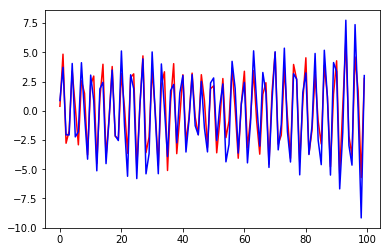

In [70]:
plt.plot(range(100),preds[:100], 'r', y_test[:100], 'b')